> Martin Fridrich 12/2024

# Regression with Keras

## Problem statement

### A. Build a Baseline Model

Using Keras, construct a neural network with one hidden layer of 10 nodes and a ReLU activation function. Configure the model with the Adam optimizer and mean squared error (MSE) as the loss function. Split the dataset into 70% training and 30% testing using scikit-learn’s `train_test_split`. Train the model for 50 epochs on the training data and evaluate its performance on the test set by calculating the MSE with `mean_squared_error`. Repeat this process 50 times to generate a list of MSEs, then report the mean and standard deviation. Submit your Jupyter Notebook with all code and comments.

### B. Normalize the Data

Repeat Part A, but first normalize each predictor by subtracting its mean and dividing by its standard deviation. After normalization, split the data into 70% training and 30% testing, build and train the same neural network for 50 epochs, and evaluate using MSE. Perform 50 iterations to collect MSEs and report their mean and standard deviation.  
**Question:** How does the mean of the mean squared errors compare to that from Part A?

### C. Increase the Number of Epochs

Building on Part B, increase the training epochs from 50 to 100. Using the normalized data, split it into 70% training and 30% testing, build the neural network with one hidden layer of 10 nodes and ReLU activation, then train for 100 epochs. Evaluate the model using MSE, repeat the process 50 times, and report the mean and standard deviation of the MSEs.  
**Question:** How does the mean of the mean squared errors compare to that from Part B?

### D. Increase the Number of Hidden Layers

Continuing from Part B, modify the neural network to include three hidden layers, each with 10 nodes and a ReLU activation function. Normalize the data, split into 70% training and 30% testing, then train the model for 50 epochs using the Adam optimizer and MSE loss. Evaluate with MSE, repeat 50 times, and report the mean and standard deviation of the MSEs.  
**Question:** How does the mean of the mean squared errors compare to that from Part B?

**Submission:** Ensure your Jupyter Notebook includes all necessary code, explanations, and answers to the questions.


## Solution

To reduce code duplication, we created a `DataUtils` class for downloading and loading data and a `RegressionExperiment` class for handling data splitting, model creation, training, and evaluation. This modular approach enhances code reuse and maintainability. Refer to the implementation for further details.

### Data loading

In [1]:
# Import necessary libraries
import os          # OS operations
import requests    # HTTP requests
import shutil      # File operations
import pandas as pd # Data manipulation

class DataUtils:
    """
    Utility class for downloading and loading data.
    
    Attributes:
        data_url (str): URL to download data.
        local_path (str): Path to save data locally.
        local_path_dir (str): Directory of the local path.
        df (pd.DataFrame): Loaded DataFrame.
    """
    
    def __init__(self, data_url, local_path):
        """
        Initializes with data URL and local path.
        
        Args:
            data_url (str): Data source URL.
            local_path (str): Local storage path.
        """
        self.data_url = data_url
        self.local_path = local_path

    def _make_path(self):
        """Creates the directory for the local path."""
        self.local_path_dir = os.path.dirname(self.local_path)
        os.makedirs(self.local_path_dir, exist_ok=True)

    def _download(self):
        """Downloads data if not already present."""
        if not os.path.exists(self.local_path):
            print("Downloading data...")
            try:
                response = requests.get(self.data_url)
                with open(self.local_path, "wb") as f:
                    f.write(response.content)
                print("Download successful.")
            except Exception as e:
                print(f"Download failed: {e}")

    def _load(self):
        """Loads the CSV data into a DataFrame."""
        print("Loading CSV data.")
        self.df = pd.read_csv(self.local_path)

    def _rm(self):
        """Removes the data directory."""
        shutil.rmtree(self.local_path_dir)

    def load(self):
        """
        Creates path, downloads, and loads data.
        
        Returns:
            DataUtils: Instance with loaded DataFrame.
        """
        self._make_path()
        self._download()
        self._load()
        return self


### Experiments & NNs

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

class RegressionExperiment:
    """
    Conducts regression experiments using neural networks with various configurations.
    
    Attributes:
        variants (dict): Experiment setups.
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target vector.
        eval_df (pd.DataFrame): Stores evaluation results.
    """
    
    def __init__(self, variants, X, y):
        """
        Initializes with variants, features, and targets.
        
        Args:
            variants (dict): Experiment configurations.
            X (pd.DataFrame): Features.
            y (pd.Series or pd.DataFrame): Target variable.
        """
        self.variants = variants
        self.X = X.values  # Convert to NumPy array
        self.y = y.values  # Convert to NumPy array

    def get_data(self, variant, random_state):
        """
        Splits data and applies normalization if needed.
        
        Args:
            variant (str): Variant name.
            random_state (int): Seed for splitting.
        
        Returns:
            dict: Training and testing data.
        """
        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.3, random_state=random_state)
                
        # Normalize if specified
        if self.variants[variant]["data"] == "normalized":
            ss = StandardScaler().fit(X_train)
            X_train = ss.transform(X_train)
            X_test = ss.transform(X_test)

        return {
            "train": {
                "X": X_train,
                "y": y_train,
                "random_state": random_state
            },
            "test": {
                "X": X_test,
                "y": y_test,
                "random_state": random_state
            }
        }
    
    def get_regression_model(self, variant):
        """
        Builds and compiles the neural network model.
        
        Args:
            variant (str): Variant name.
        
        Returns:
            Sequential: Compiled model.
        """
        input_shape = (self.X.shape[1],)  # Input dimensions
        ann_config = self.variants[variant]["ann"]
        hidden_units = ann_config["hidden_units"]
        hidden_layers = ann_config["hidden_layers"]

        # Define layers
        model = Sequential()
        model.add(layers.Input(shape=input_shape))
        for _ in range(hidden_layers):
            model.add(layers.Dense(hidden_units, activation="relu"))
        model.add(layers.Dense(1, activation="linear"))  # Output layer
        
        # Compile model
        model.compile(
            optimizer="adam",
            loss="mean_squared_error",
            metrics=["mean_absolute_error"]
        )
        
        return model
    
    def fit_regression_model(self, data, variant):
        """
        Trains the model on training data.
        
        Args:
            data (dict): Training data.
            variant (str): Variant name.
        
        Returns:
            Sequential: Trained model.
        """
        epochs = self.variants[variant]["ann"]["epochs"]
        model = self.get_regression_model(variant)
        
        # Train the model
        model.fit(
            data["train"]["X"],
            data["train"]["y"],
            epochs=epochs,
            batch_size=8,
            verbose=0  # Suppress output
        )
        
        return model
    
    def evaluate_regression_model(self, data, model, variant):
        """
        Evaluates the model on train and test sets.
        
        Args:
            data (dict): Data splits.
            model (Sequential): Trained model.
            variant (str): Variant name.
        
        Returns:
            list: Evaluation metrics.
        """
        metrics = [mean_squared_error, mean_absolute_error, r2_score]
        results = []
        
        for set_name, set_dict in data.items():
            predictions = model.predict(set_dict["X"], verbose=0)
            temp = {metric.__name__: metric(set_dict["y"], predictions) for metric in metrics}
            temp.update({
                "random_state": set_dict["random_state"],
                "set_name": set_name,
                "variant": variant
            })
            results.append(temp)
        
        return results
    
    def evaluate_iteration(self, variant, iteration):
        """
        Runs one experiment iteration.
        
        Args:
            variant (str): Variant name.
            iteration (int): Iteration number.
        
        Returns:
            pd.DataFrame: Evaluation results.
        """
        data = self.get_data(variant, random_state=iteration)
        model = self.fit_regression_model(data, variant)
        eval_results = self.evaluate_regression_model(data, model, variant)
        return pd.DataFrame(eval_results)
         
    def parallel_evaluation(self, iterations):
        """
        Executes experiments in parallel.
        
        Args:
            iterations (int): Number of iterations per variant.
        
        Returns:
            RegressionExperiment: Self with populated eval_df.
        """
        print("Starting parallel evaluation...")
        
        # Run evaluations in parallel
        results_ls = Parallel(n_jobs=12)(
            delayed(self.evaluate_iteration)(variant, iteration)
            for iteration in range(iterations)
            for variant in self.variants.keys()
        )
        
        # Combine results
        self.eval_df = pd.concat(results_ls).reset_index(drop=True)
        print("Evaluation completed.")
        return self
    
    def print_evaluation(self):
        """Prints summary statistics for test set mse."""
        summary = self.eval_df[self.eval_df.set_name=="test"]\
            .groupby("variant").mean_squared_error.describe()
        print(summary)

    def show_evaluation(self):
        """Visualizes evaluation metrics with plots."""
        pivoted_df = self.eval_df.pivot(
            index=["variant","random_state"],
            columns=["set_name"], 
            values="mean_squared_error"
        ).reset_index()

        f, a = plt.subplots(1, 2, figsize=(9, 4.5))
        
        # Boxplot for test mse
        sns.boxplot(
            data=self.eval_df[self.eval_df.set_name=="test"],
            x="variant", y="mean_squared_error", hue="variant", palette="rocket",
            ax=a[0]
        )
        a[0].set_xlabel("")
        a[0].set_ylabel("mse on test splits")
        
        # Scatter plot of train vs test mse
        sns.scatterplot(
            x="train", y="test", data=pivoted_df,
            hue="variant", palette="rocket", ax=a[1]
        )
        sns.lineplot(
            x=[0, 300], y=[0, 300], color="gray",
            linestyle="dotted", ax=a[1]
        )
        a[1].set_xlim(0, 300)
        a[1].set_ylim(0, 300)
        a[1].set_xlabel("mse on train splits")
        a[1].set_ylabel("mse on test splits")
        a[1].legend(loc="lower right", frameon=False)

        f.tight_layout()
        plt.show()


## Run

In [3]:
# Data load
du = DataUtils(data_url="https://cocl.us/concrete_data",
          local_path="./data/concrete_data.csv")
df = du.load().df
target = "Strength"
features = [c for c in df.columns if c!=target]
del du

# Define variants
variants = {
    "A":
        {"data":"raw",
         "ann":{"hidden_layers":1,
                "hidden_units":10,
                "epochs":50}},
    "B":
        {"data":"normalized",
         "ann":{"hidden_layers":1,
                "hidden_units":10,
                "epochs":50}},

    "C":
        {"data":"normalized",
         "ann":{"hidden_layers":1,
                "hidden_units":10,
                "epochs":100}},

    "D":
        {"data":"normalized",
         "ann":{"hidden_layers":3,
                "hidden_units":10,
                "epochs":50}}}

# Heavy lifting
experiment = RegressionExperiment(variants=variants,
                                  X=df.loc[:,features], y=df.loc[:,target])
# Run parallel evaluations with 50 iterations
experiment.parallel_evaluation(iterations=50)

Loading CSV data.
Starting parallel evaluation...


2024-12-31 11:04:45.658963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use avai2024-12-31 11:04:45.658963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
lable CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 11:04:45.702561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use avai2024-12-31 11:04:45.702561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other oper

Evaluation completed.


## Discussion

We present descriptive statistics of the mean squared error (MSE) across the variants on the test set to evaluate the model (see printout below). We also created boxplots to visually assess the median and variability of the MSE and implemented scatter plots to examine the bias-variance trade-off.

In [4]:
experiment.print_evaluation()

         count        mean        std        min         25%         50%  \
variant                                                                    
A         50.0  116.000697  25.189113  61.973790  102.236421  116.746231   
B         50.0  113.383819  10.827045  90.001730  108.936834  112.831352   
C         50.0   70.041230  17.284521  50.523119   58.132004   63.842537   
D         50.0   76.694064  23.618102  44.156320   55.683508   72.004681   

                75%         max  
variant                          
A        131.590040  176.978327  
B        118.111071  157.922638  
C         76.943913  121.085761  
D         97.830108  130.851369  


The analysis indicates that variant `A` exhibits the largest mean and standard deviation, suggesting poor and unstable performance. In contrast, variant `B` shows a similar mean performance but with a very small standard deviation, indicating more stable outcomes. This stability likely results from the normalization of inputs during training.

Variant `C` demonstrates the best mean performance with a medium standard deviation, implying that the regression task is somewhat more complex, and that additional training epochs yield better overall results. Variant `D` performs slightly worse than variant `C` and has a very high standard deviation, similar to variant `A`, indicating that the task is complex enough that the model might benefit from more units and layers.

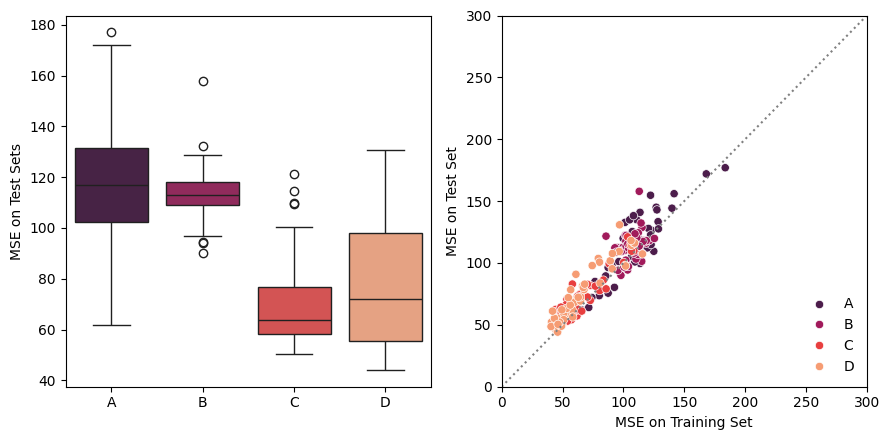

In [5]:
experiment.show_evaluation()

The boxplots on the left verify these observations. Additionally, the scatterplot shows that variants `A` and `B` struggle to capture sufficient information, even on the training set, which aligns with the assessment of the task's complexity.

> Martin Fridrich 12/2024